In [1]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 57.4 MB/s eta 0:00:00


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from collections import Counter
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
path_folder = "drive/MyDrive/THESIS/Thesis project/french_antivax/clean_code_final/"

In [12]:
df = pd.read_csv(path_folder+"data/entire_dataset_labeled_final.csv")
# Filter the rows with labels == 1
df = df[df['labels'] == 1]
df.reset_index(drop=True, inplace=True)

In [13]:
len(df)

338641

In [14]:
len(df.author_id.unique())

27016

In [15]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Keep alphabetic characters and accented letters
    text = re.sub(r'[^a-zA-ZÀ-ÿ#]', ' ', text)  # Remove non-alphabetic characters, keeping @ and #

    # Keep alphabetic characters and accented letters, replace consecutive spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Replace "non vaccinated" or "non-vaccinated" with "non_vaccinated"
    text = re.sub(r'\bnon(?:[-\s]+)vaccinés\b', 'non_vaccinés', text)
    text = re.sub(r'\bnon(?:[-\s]+)vacciné\b', 'non_vacciné', text)

    # Replace "non vaccinated" or "non-vaccinated" with "non_vaccinated"
    text = re.sub(r'\bnon(?:[-\s]+)injectés\b', 'non_injectés', text)
    text = re.sub(r'\bnon(?:[-\s]+)injecté\b', 'non_injecté', text)

#Added afterwards
    text = re.sub(r'\bnon(?:[-\s]+)vax\b', 'non_vax', text)

    text = re.sub(r'\bnon(?:[-\s]+)vaxx\b', 'non_vaxx', text)

    text = re.sub(r'\bnon(?:[-\s]+)piqués\b', 'non_piqués', text)
    text = re.sub(r'\bnon(?:[-\s]+)piqué\b', 'non_piqué', text)

    text = re.sub(r'\bnon(?:[-\s]+)spikés\b', 'non_spikés', text)
    text = re.sub(r'\bnon(?:[-\s]+)spiké\b', 'non_spiké', text)

    text = re.sub(r'\bnon(?:[-\s]+)dosés\b', 'non_dosés', text)
    text = re.sub(r'\bnon(?:[-\s]+)dosé\b', 'non_dosé', text)

    text = re.sub(r'\bnon(?:[-\s]+)vaxxinés\b', 'non_vaxxinés', text)
    text = re.sub(r'\bnon(?:[-\s]+)vaxxiné\b', 'non_vaxxiné', text)

    text = re.sub(r'\bnon(?:[-\s]+)vacc\b', 'non_vacc', text)

    text = re.sub(r'\bnon(?:[-\s]+)vacx\b', 'non_vacx', text)

    text = re.sub(r'\bnon(?:[-\s]+)vaxxés\b', 'non_vaxxés', text)

    return text.strip()

# Apply the preprocess_text function to the 'tweet' column and store the result in a new column 'preprocessed_text'
df['preprocessed_text'] = df['tweet_clean0'].apply(preprocess_text)

In [ ]:
# Filter tweets containing variations of "non vaccinated" and "non-vaccinated"
sample_tweets = df[df['tweet_clean0'].str.contains(r'\bnon(?:[-\s]+)vaccinés\b', case=False)].sample(10)

# Print the original and preprocessed tweets for inspection
for index, row in sample_tweets.iterrows():
    original_tweet = row['tweet_clean0']
    preprocessed_tweet = row['preprocessed_text']
    print(f"Original Tweet: {original_tweet}")
    print(f"Preprocessed Tweet: {preprocessed_tweet}\n")

Original Tweet: Il faut comprendre réaction de ou qui depuis le début de la pandémie #Covid tentent de rallier à eux les #antivax &amp; de se partager les 9% de non-vaccinés qui sont d’abord des anti-Macron primaires !emmerderLesNonVaccinés
Preprocessed Tweet: il faut comprendre réaction de ou qui depuis le début de la pandémie #covid tentent de rallier à eux les #antivax amp de se partager les de non_vaccinés qui sont d abord des anti macron primaires emmerderlesnonvaccinés

Original Tweet: Voilà la résistance ! 74 % du personnel non vaccinés ! #PassDeLaHonte #Manifs11septembre #Covid_19 #NonAuPassSanitaire
Preprocessed Tweet: voilà la résistance du personnel non_vaccinés #passdelahonte #manifs septembre #covid #nonaupasssanitaire

Original Tweet: Euhhh l’Autriche, on en parle ou pas ? Confiner les non-vaccinés pour protéger les vaccinés ? Je comprend pas le délire 🤔 #Autriche #StopDictatureSanitaire #HDPros #PassDeLaHonte
Preprocessed Tweet: euhhh l autriche on en parle ou pas confin

# I - Create the Word2vec models

In [16]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [17]:
# Tokenize the preprocessed text
tokenized_text = df['preprocessed_text'].apply(word_tokenize)

# # Train Word2Vec model
#model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=5, workers=4)

# # Save the trained model
#model.save("models/word2vec_model_all")

# Filter data before and after July 12th
df_before_july = df[df['created_at'] < '2021-07-12']
df_after_july = df[df['created_at'] >= '2021-07-12']

# Tokenize the preprocessed text for the data before July 12th
tokenized_text_before = df_before_july['preprocessed_text'].apply(word_tokenize)

# Train Word2Vec model for data before July 12th
#model_before_july = Word2Vec(sentences=tokenized_text_before, vector_size=100, window=5, min_count=5, workers=4)

# Save the trained model for data before July 12th
#model_before_july.save("models/word2vec_model_before_july")

# Tokenize the preprocessed text for the data after July 12th
tokenized_text_after = df_after_july['preprocessed_text'].apply(word_tokenize)

# # Train Word2Vec model for data after July 12th
#model_after_july = Word2Vec(sentences=tokenized_text_after, vector_size=100, window=5, min_count=5, workers=4)

# # Save the trained model for data after July 12th
#model_after_july.save("models/word2vec_model_after_july")


In [18]:
# Load the Word2Vec models
model = Word2Vec.load(path_folder+"models/word2vec_model_all")
model_before_july = Word2Vec.load(path_folder+"models/word2vec_model_before_july")
model_after_july = Word2Vec.load(path_folder+"models/word2vec_model_after_july")

In [19]:
df["tokenized_text"] = tokenized_text

# II. Find the outgroup words through similarity with "they" and "them"

In [ ]:
word = "ils"

# # Get the counts of each word before and after July 12th
word_counts_before_july = df_before_july['tweet_clean0'].str.split(expand=True).stack().value_counts()
word_counts_after_july = df_after_july['tweet_clean0'].str.split(expand=True).stack().value_counts()

# # Combine word counts from before and after July 12th
#word_counts_total = word_counts_before_july.add(word_counts_after_july, fill_value=0)

# # Filter out words that occur less than 50 times in total
words_occurred_at_least_20_total_bef = word_counts_before_july[word_counts_before_july >= 20].index.tolist()
words_occurred_at_least_20_total_aft = word_counts_after_july[word_counts_after_july >= 20].index.tolist()

# Example of getting similar words to 'eux' for each model
similar_words_before_july = model_before_july.wv.most_similar(word, topn=50)
similar_words_after_july = model_after_july.wv.most_similar(word, topn=50)

# Filter similar words to include only those that occurred at least 50 times in total
similar_words_before_july_filtered = [(word, similarity) for word, similarity in similar_words_before_july if word in words_occurred_at_least_20_total_bef]
similar_words_after_july_filtered = [(word, similarity) for word, similarity in similar_words_after_july if word in words_occurred_at_least_20_total_aft]

# Print filtered similar words
print(f'Similar words to "{word}" before and after July 12th that occurred at least 20 times in total: {similar_words_before_july_filtered}')
print(f'Similar words to "{word}" before and after July 12th that occurred at least 20 times in total: {similar_words_after_july_filtered}')
print()

Similar words to "ils" before and after July 12th that occurred at least 20 times in total: [('elles', 0.733900249004364), ('ceux', 0.5642030835151672), ('gens', 0.5443803071975708), ('certains', 0.5085021257400513), ('eux', 0.5049986243247986), ('seuls', 0.4496482014656067), ('vaccinés', 0.4300522208213806), ('français', 0.4257791340351105), ('confiner', 0.4148330092430115), ('leur', 0.41390204429626465), ('mêmes', 0.40699782967567444), ('leurs', 0.3793514370918274), ('francais', 0.3789125978946686), ('lobotomisés', 0.3787713050842285), ('élus', 0.37459954619407654), ('députés', 0.3745819628238678), ('moutons', 0.3740063011646271), ('prêts', 0.36063629388809204), ('médias', 0.36029455065727234), ('parlementaires', 0.35980546474456787), ('complotistes', 0.35673320293426514), ('américains', 0.35628870129585266), ('qui', 0.35256609320640564), ('gouvernants', 0.35011914372444153), ('parents', 0.3496268391609192), ('reconfiner', 0.3443922698497772), ('tant', 0.3311161994934082), ('gouverne

In [ ]:
word = "eux"

# # Get the counts of each word before and after July 12th
word_counts_before_july = df_before_july['tweet_clean0'].str.split(expand=True).stack().value_counts()
word_counts_after_july = df_after_july['tweet_clean0'].str.split(expand=True).stack().value_counts()

# # Combine word counts from before and after July 12th
#word_counts_total = word_counts_before_july.add(word_counts_after_july, fill_value=0)

# # Filter out words that occur less than 50 times in total
words_occurred_at_least_20_total_bef = word_counts_before_july[word_counts_before_july >= 20].index.tolist()
words_occurred_at_least_20_total_aft = word_counts_after_july[word_counts_after_july >= 20].index.tolist()

# Example of getting similar words to 'eux' for each model
similar_words_before_july = model_before_july.wv.most_similar(word, topn=50)
similar_words_after_july = model_after_july.wv.most_similar(word, topn=50)

# Filter similar words to include only those that occurred at least 50 times in total
similar_words_before_july_filtered = [(word, similarity) for word, similarity in similar_words_before_july if word in words_occurred_at_least_20_total_bef]
similar_words_after_july_filtered = [(word, similarity) for word, similarity in similar_words_after_july if word in words_occurred_at_least_20_total_aft]

# Print filtered similar words
print(f'Similar words to "{word}" before and after July 12th that occurred at least 20 times in total: {similar_words_before_july_filtered}')
print(f'Similar words to "{word}" before and after July 12th that occurred at least 20 times in total: {similar_words_after_july_filtered}')
print()

Similar words to "eux" before and after July 12th that occurred at least 20 times in total: [('ceux', 0.5617684125900269), ('vaccinés', 0.5596469044685364), ('certains', 0.552836000919342), ('autres', 0.5526029467582703), ('jeunes', 0.5372572541236877), ('seuls', 0.5229650139808655), ('mêmes', 0.5174791812896729), ('soi', 0.5089643597602844), ('ils', 0.5049986243247986), ('elles', 0.5006486773490906), ('toujours', 0.5003610253334045), ('gens', 0.500307559967041), ('protéger', 0.49965164065361023), ('confiner', 0.4951787292957306), ('rester', 0.47614380717277527), ('moi', 0.47445571422576904), ('adultes', 0.4653289318084717), ('ailleurs', 0.4610934853553772), ('les', 0.45944705605506897), ('moutons', 0.4571528136730194), ('lobotomisés', 0.4456292986869812), ('survivre', 0.44427385926246643), ('savoir', 0.44414758682250977), ('bons', 0.4431925415992737), ('enfants', 0.44051194190979004), ('soignants', 0.4394923448562622), ('mourir', 0.4368712604045868), ('leurs', 0.43208634853363037), ('

In [ ]:
outgroup_words_gpt_1 = [
    "ceux", "vaccinés", "français", "francais", "lobotomisés", "élus",
    "députés", "moutons", "médias", "parlementaires", "complotistes", "américains",
    "gouvernants", "gouvernements", "militaires", "labos", "élites", "covidistes",
    "flics", "préfets", "spikés", "fdo", "nazis", "idiots", "juges", "dirigeants",
    "personnes", "gueux", "employeurs", "contraints", "esclaves", "électeurs",
    "policiers", "politiques", "italiens", "israéliens"
]

manually_added = ["injectés", "abrutis"]#
outgroup_words_first_round = outgroup_words_gpt_1 + manually_added

In [ ]:
len(outgroup_words_first_round)

38

In [ ]:
# Get the counts of each word before and after July 12th
word_counts_before_july = df_before_july['tweet_clean0'].str.split(expand=True).stack().value_counts()
word_counts_after_july = df_after_july['tweet_clean0'].str.split(expand=True).stack().value_counts()

# Create sets to store all unique similar words
all_similar_words_before = set()
all_similar_words_after = set()

for word in outgroup_words_first_round:
    if word == "spikés":
        similar_words_after_july = model_after_july.wv.most_similar(word, topn=50)
        similar_words_after_july_filtered = [(w, similarity) for w, similarity in similar_words_after_july if w in words_occurred_at_least_20_total_aft]

        # Add to the set of unique words
        all_similar_words_after.update([w for w, _ in similar_words_after_july_filtered])

        print(f'Similar words to "{word}" after July 12th that occurred at least 20 times in total: {similar_words_after_july_filtered}')
        print("###########################################################")

    else:
        similar_words_before_july = model_before_july.wv.most_similar(word, topn=50)
        similar_words_after_july = model_after_july.wv.most_similar(word, topn=50)

        # Filter similar words to include only those that occurred at least 20 times in total
        similar_words_before_july_filtered = [(w, similarity) for w, similarity in similar_words_before_july if w in words_occurred_at_least_20_total_bef]
        similar_words_after_july_filtered = [(w, similarity) for w, similarity in similar_words_after_july if w in words_occurred_at_least_20_total_aft]

        # Add to the sets of unique words
        all_similar_words_before.update([w for w, _ in similar_words_before_july_filtered])
        all_similar_words_after.update([w for w, _ in similar_words_after_july_filtered])

        # Print filtered similar words
        print(f'Similar words to "{word}" before July 12th that occurred at least 20 times in total: {similar_words_before_july_filtered}')
        print(f'Similar words to "{word}" after July 12th that occurred at least 20 times in total: {similar_words_after_july_filtered}')
        print("###########################################################")

# Print the final sets of unique words
print("\n" + "="*80)
print("UNIQUE SIMILAR WORDS SUMMARY:")
print("="*80)
print(f"All unique similar words before July 12th ({len(all_similar_words_before)} words):")
print(sorted(all_similar_words_before))
print(f"\nAll unique similar words after July 12th ({len(all_similar_words_after)} words):")
print(sorted(all_similar_words_after))

Similar words to "ceux" before July 12th that occurred at least 20 times in total: [('gens', 0.6157886385917664), ('certains', 0.594371497631073), ('ils', 0.5642029643058777), ('eux', 0.5617684125900269), ('elles', 0.536645233631134), ('mêmes', 0.530191957950592), ('personnes', 0.5078669190406799), ('élus', 0.5029361844062805), ('seuls', 0.4883195161819458), ('jeunes', 0.48500877618789673), ('médecins', 0.47796955704689026), ('voté', 0.474261075258255), ('français', 0.4689417779445648), ('lobotomisés', 0.4671992063522339), ('vaccinés', 0.46166008710861206), ('celles', 0.454784095287323), ('députés', 0.4453018307685852), ('américains', 0.4374307096004486), ('ces', 0.4361545443534851), ('soignants', 0.4265905022621155), ('prêts', 0.42601531744003296), ('répondu', 0.4158244729042053), ('francais', 0.40935027599334717), ('policiers', 0.40366020798683167), ('beaucoup', 0.4020281136035919), ('lieux', 0.40013736486434937), ('passés', 0.39813485741615295), ('moutons', 0.39580750465393066), ('c

In [ ]:
all_similar_words_before_after = list(set(list(all_similar_words_before) + list(all_similar_words_after)))

In [ ]:
print(all_similar_words_before_after)

['hôpitaux', 'chiffres', 'conclusions', 'menteurs', 'hystériques', 'protocoles', 'esprits', 'vaxx', 'êtres', 'habitude', 'ils', 'oreilles', 'extrémistes', 'moyens', 'dommages', 'restaus', 'cas', 'services', 'compétences', 'gamins', 'manipulés', 'enfants', 'types', 'clients', 'conséquences', 'aînés', 'actionnaires', 'assassins', 'hospitalisations', 'profits', 'privilèges', 'jugés', 'incompétents', 'contents', 'parents', 'bébés', 'clusters', 'commerçants', 'références', 'complices', 'revenus', 'chefs', 'compter', 'anges', 'récalcitrants', 'guignols', 'comparaisons', 'sociétés', 'technocrates', 'devenus', 'apprentis', 'fragiles', 'professeurs', 'expérimentaux', 'bracelets', 'alliés', 'contaminés', 'conseils', 'personnages', 'cotisations', 'menacés', 'protégés', 'chances', 'interdits', 'stades', 'injectés', 'forces', 'robots', 'contaminations', 'celui', 'larbins', 'médicaments', 'républicains', 'vaxxinés', 'préfets', 'endormis', 'nombre', 'ceux', 'électeurs', 'candidats', 'mots', 'acolytes

In [ ]:
outgroup_words_gpt = [
    'menteurs', 'hystériques', 'extrémistes', 'manipulés', 'types', 'clients',
    'actionnaires', 'assassins', 'incompétents', 'récalcitrants', 'guignols',
    'technocrates', 'contaminés', 'larbins', 'républicains', 'vaxxinés',
    'électeurs', 'candidats', 'acolytes', 'khmers', 'clowns', 'imbéciles',
    'antisémites', 'soldats', 'terrorisés', 'zombies', 'toutous', 'salopards',
    'neuneus', 'coupables', 'fascistes', 'russes', 'collabos', 'aveugles',
    'bobos', 'migrants', 'contaminants', 'obéissants', 'propagandistes',
    'pourritures', 'policiers', 'gueux', 'alarmistes', 'motards', 'pleutres',
    'abrutis', 'fachos', 'macronards', 'connards', 'nuls', 'criminels',
    'merdias', 'enfermistes', 'godillots', 'réfractaires', 'méchants', 'ennemis',
    'opposants', 'enfoirés', 'dictateurs', 'maîtres', 'parias', 'marionnettes',
    'tyrans', 'dégénérés', 'monstres', 'juifs', 'ordures', 'sales', 'zélés',
    'racailles', 'clandestins', 'psychopathes', 'ignorants', 'apeurés', 'idiots',
    'manipulateurs', 'corrompus', 'rats', 'stupides', 'étrangers', 'escrocs',
    'vilains', 'crétins', 'pestiférés', 'kapos', 'parasites', 'cocus', 'incultes',
    'ignobles', 'décérébrés', 'salauds', 'macronistes', 'libéraux', 'tyrans',
    'dictatures', 'nazis', 'provax', 'vaccinés', 'vaccines', 'autres', 'peuple',
    'compatriotes', 'moutons', 'mainstream', 'minorités', 'populations', 'peuples',
    'voyageurs', 'oppositions', 'opposants', 'proches', 'alliés', 'autres', 'étrangers'
] + outgroup_words_gpt_1
len(outgroup_words_gpt)

151

In [ ]:
outgroup_words_manually = ['gouvernement', 'moutons', 'flics', 'élus', 'covidistes', 'élites', 'parlementaires', 'vaccinés', 'médias', 'fdo', 'lobotomisés',
                           'dirigeants', 'députés', 'policiers', 'préfets', 'boomers', 'nazis', 'injectés', 'macronistes', 'esclaves', 'politiciens', 'gouvernants',
                           'tyrans', 'dictateurs', 'terroristes', 'terroristes sanitaires', 'mondialistes', 'représentants', 'psychopathes', 'politicards',
                           'ennemis', 'vendus', 'larbins', 'lâches', 'milliardaires', 'patrons', 'ordures', 'salopards', 'pions', 'enfermistes', 'tarés', 'escrocs',
                           'maîtres', 'pourris', 'autorités', 'collabos', 'charlatans', 'riches', 'crapules', 'mougeons', 'abrutis', 'décérébrés', 'crétins', 'nantis',
                           'fous', 'fachos', 'dociles', 'connards', 'journalistes', 'naïfs', 'clowns', 'aveugles', 'hypocondriaques', 'merdias', 'président', 'ministres',
                           'sénateurs', 'alarmistes', 'fanatiques', 'bobos', 'leaders', 'monstres', 'pourritures', 'manipulateurs', 'propagandistes', 'parasites', 'salauds',
                           'socialistes', 'macronards', 'marionnettes', 'vax', 'vaxx', 'provax', 'piqués', 'spikés', 'dosés', 'vaxxinés', 'vacc', 'vacx', 'labos', 'experts',
                           'journaleux', 'menteurs', 'khmers', 'hypnotisés', 'pleutres', 'toutous', 'terrorisés', 'ignorants', 'veaux', 'manipulés', 'bêtes', 'incultes',
                           'obéissants', 'muselés', 'ayatollahs', 'traîtres', 'godillots', 'sbires', 'idiots', 'fascistes', 'maires', 'toubibs', 'laboratoires', 'technocrates',
                           'guignols', 'pantins', 'merdes', 'vaxxés', 'vaccinaux', 'voyous', 'talibans', 'endoctrinés', 'allemands', 'journalopes', 'scientifiques', 'lobbies',
                           'délinquants', 'hystériques', 'militaires', 'assassins', 'minables', 'chaînes', 'sorciers', 'juristes', 'actionnaires', 'docteurs', 'apeurés',
                           'débiles', 'traitres', 'imbéciles', 'mixtures', 'enfoirés', 'mainstream', 'puissants', 'robots', 'poisons', 'spécialistes', 'kapos', 'mensonges',
                           'thérapies', 'médecins', 'gueux', 'juifs', 'complotistes', 'piquouzes', 'zélés', 'demeurés', 'dingues', 'intellectuels', 'pharmaceutiques',
                           'corrompus', 'cobayes', 'dictatures', 'banques', 'plateaux', 'endormis', 'juges', 'zombies', 'gouvernements', 'tribunaux', 'institutions', 'présidents', 'complices']

In [ ]:
# Added mually after: ["ayatollahs", "vacc", "hypnotisés", "terroristes sanitaires",
#  "vaccinaux", "talibans", "gouvernement", "président", "endoctrinés", "vaxxés", "voyous"]

In [ ]:
list1 = outgroup_words_gpt
list2 = outgroup_words_manually

# Convert to sets
set1 = set(list1)
set2 = set(list2)

# In list1 but not in list2
only_in_list1 = set1 - set2

# In list2 but not in list1
only_in_list2 = set2 - set1

# In both
in_both = set1 & set2

print(f"Only in list1 ({len(only_in_list1)}):", only_in_list1)
print(f"Only in list2 ({len(only_in_list2)}):", only_in_list2)
print(f"In both ({len(in_both)}):", in_both)


Only in list1 (57): {'racailles', 'dégénérés', 'stupides', 'peuples', 'sales', 'récalcitrants', 'électeurs', 'étrangers', 'francais', 'français', 'antisémites', 'politiques', 'minorités', 'américains', 'personnes', 'nuls', 'types', 'parias', 'populations', 'ceux', 'autres', 'rats', 'opposants', 'motards', 'candidats', 'clients', 'contaminés', 'pestiférés', 'alliés', 'républicains', 'neuneus', 'acolytes', 'extrémistes', 'italiens', 'voyageurs', 'clandestins', 'peuple', 'ignobles', 'contraints', 'migrants', 'cocus', 'coupables', 'vaccines', 'oppositions', 'réfractaires', 'soldats', 'méchants', 'proches', 'criminels', 'libéraux', 'employeurs', 'israéliens', 'russes', 'vilains', 'incompétents', 'contaminants', 'compatriotes'}
Only in list2 (91): {'journalopes', 'hypocondriaques', 'terroristes', 'traitres', 'nantis', 'fanatiques', 'présidents', 'vacc', 'thérapies', 'pourris', 'représentants', 'lâches', 'vendus', 'ayatollahs', 'médecins', 'délinquants', 'poisons', 'minables', 'allemands', 'd

In [ ]:
len(set(outgroup_words_gpt + outgroup_words_manually))

231

# III. Manually check the outgroup words found

In [ ]:
#This is the way I checked for each word

import re

# Define the word you're searching for
word = 'complices'

# Construct the regular expression pattern with word boundaries
pattern = r'\b' + re.escape(word) + r'\b'

# Filter tweets containing the word
tweets_with_word = df[df['preprocessed_text'].str.contains(pattern, case=False)]

# Display the number of tweets containing the word
#print(f"Number of tweets containing the word '{word}':", len(tweets_with_word))

# Display a sample of tweets containing the word
sample_tweets = tweets_with_word.sample(20, random_state=42)['tweet'].tolist()
for i, tweet in enumerate(sample_tweets, 1):
    print(f"{i}. {tweet}\n")

""

Number of tweets containing the word 'complices': 523
1. @Cheap_Sandwich @soundtrue2 Non ! ni aveugles, ni ignorants... Simplement complices... 💉😡

#EffetsSecondairesDesVaccins
#NonAuVaccinObligatoire
#NonAuPassSanitaire
#NonAuPasseDeLaHonte

2. #NonAuPassSanitaire 
#liberté 
On se moque de nous ouvertement.
Le seul drame qu'il y a en France sont le mensonge et la peur distillés en permanence par le gouvernement et son chef d'état totalitaire à l'aide de ses conseillers complices.
#Corruption https://t.co/mqmGBXDLzV

3. @CNEWS @BFMTV @LCI @TF1 @Francetele vs êtes tous complices de tout ça, de tous les mensonges d'Etat, et dans ce cas on dit de vs que vs êtes des COLLABOS!!!!! Sauf @france_soir qui eux font leur boulot, montre les vérités. La révolution arrive #DictatureSanitaire #Dictature

4. @ClaireJardin1 Plus simple, plus fluide, mais moins confidentiel pour nos données médicales. Merci @GroupeSNCF et @AirFranceFR qui se rendent complices de discriminations ! #NonAuPassSanitaire #N

''

In [20]:
from tkinter.constants import N
#For each outgroup word, check if they are used more than 75% of the time to refer to the outgroup. The numbers indicate, out of 20 tweets, how many tweets did refer to the outgroup using that word.

outgroup_words_dict_manual = {"gouvernement": 20,
                       "moutons": 19,
                       "flics": 20,
                       "élus": 12,
                       "covidistes": 20,
                       "élites": 19,
                       "parlementaires": 10,
                       "vaccinés": 16,
                       "médias": 17,
                       "fdo": 17,
                       "lobotomisés": 19,
                       "dirigeants": 20,
                       "députés": 9,
                       "policiers": 13,
                       "préfets": 19,
                       "boomers": 18,
                       "nazis": 19,
                       "injectés": 12,
                       "macronistes": 18,
                       "esclaves": 15,
                       "politiciens": 20,
                       "gouvernants": 20,
                       "tyrans": 20,
                       "dictateurs": 20,
                       "terroristes": 10,
                       "terroristes sanitaires": 20,
                       "mondialistes": 20,
                       "représentants": 13,
                       "psychopathes": 20,
                       "politicards": 20,
                       "ennemis": 14,
                       "vendus": 19,
                       "larbins": 20,
                       "lâches": 20,
                       "milliardaires": 20,
                       "patrons": 6,
                       "ordures":  19,
                       "salopards": 19,
                       "pions": 11,
                       "enfermistes": 19,
                       "tarés": 19,
                       "escrocs": 20,
                       "maîtres": 19,
                       "pourris": 18,
                       "autorités": 16,
                       "collabos": 20,
                       "charlatans": 20,
                       "riches": 13,
                       "crapules": 20,
                       "mougeons": 20,
                       "abrutis": 14,
                       "décérébrés": 16,
                       "crétins": 15,
                       "nantis": 20,
                       "fous": 9,
                       "fachos": 18,
                       "dociles": 16,
                       "connards": 16,
                       "journalistes": 20,
                       "naïfs": 20,
                       "clowns": 19,
                       "aveugles": 19,
                       "hypocondriaques": 20,
                       "merdias": 20,
                       "président": 16,
                       "ministres": 18,
                       "sénateurs": 13,
                       "alarmistes": 20,
                       "fanatiques": 20,
                       "bobos": 17,
                       "leaders": 18,
                       "monstres": 17,
                       "pourritures": 20,
                       "manipulateurs": 20,
                       "propagandistes": 20,
                       "parasites": 18,
                       "salauds": 18,
                       "socialistes": 19,
                       "macronards": 20,
                       "marionnettes": 18,
                       "vax": 8,
                       "vaxx": 9,
                       "provax": 18,
                       "piqués": 14,
                       "spikés": 19,
                       "dosés": 17,
                       "vaxxinés": 18,
                       "vacc": 3,
                       "vacx": 12,
                       "labos": 20,
                       "experts": 9,
                       "journaleux": 20,
                       "menteurs": 20,
                       "khmers": 19,
                       "hypnotisés": 20,
                       "pleutres": 20,
                       "toutous": 18,
                       "terrorisés": 18,
                       "ignorants": 19,
                       "veaux": 20,
                       "manipulés": 11,
                       "bêtes": 15,
                       "incultes": 15,
                       "obéissants": 17,
                       "muselés": 11,
                       "ayatollahs": 20,
                       "traîtres": 20,
                       "godillots": 20,
                       "sbires": 20,
                       "idiots": 12,
                       "fascistes": 16,
                       "maires": 10,
                       "toubibs": 15,
                       "laboratoires": 19,
                       "technocrates": 20,
                       "guignols": 20,
                       "pantins": 20,
                       "merdes": 10,
                       "vaxxés": 19,
                       "vaccinaux": 5,
                       "voyous": 20,
                       "talibans": 20,
                       "endoctrinés": 20,
                       "allemands": 8,
                       "journalopes": 20,
                       "scientifiques": 8,
                       "lobbies": 20,
                       "délinquants": 3,
                       "hystériques": 16,
                       "militaires": 3,
                       "assassins": 17,
                       "minables": 17,
                       "chaînes": 15,
                       "sorciers": 19,
                       "juristes": 2,
                       "actionnaires": 20,
                       "docteurs": 8,
                       "apeurés": 19,
                       "débiles": 7,
                       "traitres": 20,
                       "imbéciles": 8,
                       "mixtures": 0,
                       "provax": 17,
                       "enfoirés": 17,
                       "mainstream": 0,
                       "puissants": 17,
                       "robots": 6,
                       "poisons": 0,
                       "spécialistes": 8,
                       "kapos": 20,
                       "mensonges": 0,
                       "thérapies": 0,
                       "médecins": 5,
                       "gueux": 0,
                       "juifs": 0,
                       "complotistes": 3,
                       "piquouzes": 0,
                       "zélés": 17,
                       "demeurés": 3,
                       "dingues": 18,
                       "intellectuels": 10,
                       "pharmaceutiques": 0,
                       "corrompus": 20,
                       "cobayes": 0,
                       "dictatures": 0,
                       "banques": 4,
                       "plateaux": 0,
                       "endormis": 18,
                       "juges": 2,
                       "zombies": 16,
                       "gouvernements": 17,
                       "tribunaux": 0,
                       "institutions": 18,
                       "présidents": 17,
                       "sales": 16,
                       "coupables": 13,
                       "russes": 6,
                       "rats": 18,
                       "réfractaires": 0,
                       "cocus": 20,
                       "méchants": 7,
                       "stupides": 10,
                       "voyageurs": 5,
                       "alliés": 16,
                       "antisémites": 0,
                       "contaminés": 4,
                       "motards": 2,
                       "extrémistes": 6,
                       "peuple": 0,
                       "criminels": 9,
                       "autres": 4,
                       "compatriotes": 6,
                       "soldats": 10,
                       "ignobles": 12,
                       "proches": 3,
                       "dégénérés": 19,
                       "libéraux": 10,
                       "étrangers": 4,
                       "racailles": 20,
                       "parias": 1,
                       "types": 11,
                       "migrants": 17,
                       "peuples": 1,
                       "clandestins": 3,
                       "clients": 1,
                       "populations": 0,
                       "minorités": 9,
                       "contaminants": 9,
                       "vilains": 3,
                       "républicains": 10,
                       "opposants": 0,
                       "incompétents": 18,
                       "pestiférés": 0,
                       "nuls": 16,
                       "électeurs": 8,
                       "candidats": 13,
                       "oppositions": 8,
                       "acolytes": 20,
                       "neuneus": 4,
                       "vaccines": 6,
                       "récalcitrants": 0,
                       "israéliens": 13,
                       "français": 2,
                       "ceux": 11,
                       "politiques": 11,
                       "francais": 1,
                       "employeurs": 15,
                       "contraints": 10,
                       "personnes": 3,
                       "américains": 5,
                       "italiens": 0,
                       "complices": 20
                       }

In [21]:
len(outgroup_words_dict_manual.keys())

231

In [ ]:
# Initialize client
client = OpenAI(api_key="")

In [ ]:
import re
import json
from openai import OpenAI

# Pick only the first 3 keys for testing
test_words = list(outgroup_words_dict.keys())[:3]

results = {}

for word in test_words:
    # Regex pattern
    pattern = r'\b' + re.escape(word) + r'\b'

    # Filter tweets containing the word
    tweets_with_word = df[df['preprocessed_text'].str.contains(pattern, case=False)]

    if tweets_with_word.empty:
        print(f"No tweets found for '{word}'")
        results[word] = {"tweets": [], "response": "No tweets found"}
    else:
        # Sample up to 20 tweets
        sample_tweets = tweets_with_word.sample(20, random_state=42)['tweet'].tolist()

        # Build the prompt
        tweets_text = "\n".join([f"{i+1}. {t}" for i, t in enumerate(sample_tweets)])
        prompt = (
            f"These tweets are written by people criticizing vaccine-related policies or resisting vaccine mandates "
            f"or non-vaccinated people. In how many of these tweets do they use the term '{word}' to refer to people "
            f"in France who are distinct from those criticizing vaccine-related policies or resisting vaccine mandates "
            f"or non-vaccinated people? Return an explanation for each tweet and the final count.\n\n"
            f"Here are the tweets:\n{tweets_text}"
        )

        # Send request to OpenAI
        response = client.responses.create(
            model="gpt-5",
            input=prompt,
            store=True,
        )

        results[word] = {
            "tweets": sample_tweets,
            "response": response.output_text
        }

    # ✅ Save progress after each word
    with open(path_folder+"results/outgroup_analysis.json", "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)

    print(f"\n=== Finished '{word}' and saved progress ===\n")

print("\n✅ All results processed and saved to 'outgroup_analysis.json'")



=== Finished 'gouvernement' and saved progress ===


=== Finished 'moutons' and saved progress ===


=== Finished 'flics' and saved progress ===


✅ All results processed and saved to 'outgroup_analysis.json'


In [ ]:
import re
import json
from openai import OpenAI

# ✅ Load existing results if file exists
try:
    with open(path_folder+"results/outgroup_analysis.json", "r", encoding="utf-8") as f:
        results = json.load(f)
    print(f"Resuming: already have {len(results)} words processed.")
except FileNotFoundError:
    results = {}
    print("Resuming.")

# Process remaining words
for word in outgroup_words_dict.keys():
    if word in results:  # ✅ Skip words already done
        print(f"Skipping '{word}', already processed.")
        continue

    # Regex pattern
    pattern = r'\b' + re.escape(word) + r'\b'

    # Filter tweets containing the word
    tweets_with_word = df[df['preprocessed_text'].str.contains(pattern, case=False)]

    if tweets_with_word.empty:
        print(f"No tweets found for '{word}'")
        results[word] = {"tweets": [], "response": "No tweets found"}
    else:
        # Sample up to 20 tweets
        sample_tweets = tweets_with_word.sample(20, random_state=42)['tweet'].tolist()

        # Build the prompt
        tweets_text = "\n".join([f"{i+1}. {t}" for i, t in enumerate(sample_tweets)])
        prompt = (
            f"These tweets are written by people criticizing vaccine-related policies or resisting vaccine mandates "
            f"or non-vaccinated people. In how many of these tweets do they use the term '{word}' to refer to people "
            f"in France who are distinct from those criticizing vaccine-related policies or resisting vaccine mandates "
            f"or non-vaccinated people? Return an explanation for each tweet and the final count.\n\n"
            f"Here are the tweets:\n{tweets_text}"
        )

        # Send request to OpenAI
        response = client.responses.create(
            model="gpt-5",
            input=prompt,
            store=True,
        )

        results[word] = {
            "tweets": sample_tweets,
            "response": response.output_text
        }

    # ✅ Save progress after each word
    with open(path_folder+"results/outgroup_analysis.json", "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)

    print(f"\n=== Finished '{word}' and saved progress ===\n")

print("\n✅ All remaining words processed and added to 'outgroup_analysis.json'")

Resuming: already have 3 words processed.
Skipping 'gouvernement', already processed.
Skipping 'moutons', already processed.
Skipping 'flics', already processed.

=== Finished 'élus' and saved progress ===


=== Finished 'covidistes' and saved progress ===


=== Finished 'élites' and saved progress ===


=== Finished 'parlementaires' and saved progress ===


=== Finished 'vaccinés' and saved progress ===


=== Finished 'médias' and saved progress ===


=== Finished 'fdo' and saved progress ===


=== Finished 'lobotomisés' and saved progress ===


=== Finished 'dirigeants' and saved progress ===


=== Finished 'députés' and saved progress ===


=== Finished 'policiers' and saved progress ===


=== Finished 'préfets' and saved progress ===


=== Finished 'boomers' and saved progress ===


=== Finished 'nazis' and saved progress ===


=== Finished 'injectés' and saved progress ===


=== Finished 'macronistes' and saved progress ===


=== Finished 'esclaves' and saved progress ===


=== Fi

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
import re
import json
from openai import OpenAI

# ✅ Load existing results if file exists
try:
    with open(path_folder+"results/outgroup_analysis.json", "r", encoding="utf-8") as f:
        results = json.load(f)
    print(f"Resuming: already have {len(results)} words processed.")
except FileNotFoundError:
    results = {}
    print("Resuming.")

# Process remaining words
for word in outgroup_words_dict.keys():
    if word in results:  # ✅ Skip words already done
        print(f"Skipping '{word}', already processed.")
        continue

    # Regex pattern
    pattern = r'\b' + re.escape(word) + r'\b'

    # Filter tweets containing the word
    tweets_with_word = df[df['preprocessed_text'].str.contains(pattern, case=False)]

    if tweets_with_word.empty:
        print(f"No tweets found for '{word}'")
        results[word] = {"tweets": [], "response": "No tweets found"}
    else:
        # Sample up to 20 tweets
        sample_tweets = tweets_with_word.sample(20, random_state=42)['tweet'].tolist()

        # Build the prompt
        tweets_text = "\n".join([f"{i+1}. {t}" for i, t in enumerate(sample_tweets)])
        prompt = (
            f"These tweets are written by people criticizing vaccine-related policies or resisting vaccine mandates "
            f"or non-vaccinated people. In how many of these tweets do they use the term '{word}' to refer to people "
            f"in France who are distinct from those criticizing vaccine-related policies or resisting vaccine mandates "
            f"or non-vaccinated people? Return an explanation for each tweet and the final count.\n\n"
            f"Here are the tweets:\n{tweets_text}"
        )

        # Send request to OpenAI
        response = client.responses.create(
            model="gpt-5",
            input=prompt,
            store=True,
        )

        results[word] = {
            "tweets": sample_tweets,
            "response": response.output_text
        }

    # ✅ Save progress after each word
    with open(path_folder+"results/outgroup_analysis.json", "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)

    print(f"\n=== Finished '{word}' and saved progress ===\n")

print("\n✅ All remaining words processed and added to 'outgroup_analysis.json'")

Resuming: already have 127 words processed.
Skipping 'gouvernement', already processed.
Skipping 'moutons', already processed.
Skipping 'flics', already processed.
Skipping 'élus', already processed.
Skipping 'covidistes', already processed.
Skipping 'élites', already processed.
Skipping 'parlementaires', already processed.
Skipping 'vaccinés', already processed.
Skipping 'médias', already processed.
Skipping 'fdo', already processed.
Skipping 'lobotomisés', already processed.
Skipping 'dirigeants', already processed.
Skipping 'députés', already processed.
Skipping 'policiers', already processed.
Skipping 'préfets', already processed.
Skipping 'boomers', already processed.
Skipping 'nazis', already processed.
Skipping 'injectés', already processed.
Skipping 'macronistes', already processed.
Skipping 'esclaves', already processed.
Skipping 'politiciens', already processed.
Skipping 'gouvernants', already processed.
Skipping 'tyrans', already processed.
Skipping 'dictateurs', already pro

In [22]:
outgroup_words_dict_gpt = {"gouvernement": 19,
                       "moutons": 19,
                       "flics": 19,
                       "élus": 18,
                       "covidistes": 20,
                       "élites": 18,
                       "parlementaires": 19,
                       "vaccinés": 15,
                       "médias": 16,
                       "fdo": 18,
                       "lobotomisés": 18,
                       "dirigeants": 17,
                       "députés": 12,
                       "policiers": 17,
                       "préfets": 19,
                       "boomers": 18,
                       "nazis": 8,
                       "injectés": 15,
                       "macronistes": 20,
                       "esclaves": 16,
                       "politiciens": 19,
                       "gouvernants": 19,
                       "tyrans": 16,
                       "dictateurs": 17,
                       "terroristes": 14,
                       "terroristes sanitaires": 19,
                       "mondialistes": 6,
                       "représentants": 19,
                       "psychopathes": 14,
                       "politicards": 19,
                       "ennemis": 9,
                       "vendus": 18,
                       "larbins": 19,
                       "lâches": 20,
                       "milliardaires": 9,
                       "patrons": 7,
                       "ordures":  14,
                       "salopards": 19,
                       "pions": 10,
                       "enfermistes": 19,
                       "tarés": 19,
                       "escrocs": 15,
                       "maîtres": 13,
                       "pourris": 13,
                       "autorités": 9,
                       "collabos": 19,
                       "charlatans": 18,
                       "riches": 6,
                       "crapules": 19,
                       "mougeons": 20,
                       "abrutis": 10,
                       "décérébrés": 15,
                       "crétins": 14,
                       "nantis": 19,
                       "fous": 11,
                       "fachos": 15,
                       "salopards": 14,
                       "dociles": 19,
                       "connards": 13,
                       "journalistes": 19,
                       "naïfs": 17,
                       "clowns": 19,
                       "aveugles": 14,
                       "hypocondriaques": 19,
                       "merdias": 19,
                       "président": 20,
                       "ministres": 20,
                       "sénateurs": 19,
                       "alarmistes": 16,
                       "fanatiques": 14,
                       "bobos": 17,
                       "leaders": 8,
                       "monstres": 16,
                       "pourritures": 19,
                       "manipulateurs": 18,
                       "propagandistes": 13,
                       "parasites": 15,
                       "salauds": 17,
                       "socialistes": 18,
                       "macronards": 20,
                       "marionnettes": 8,
                       "vax": 10,
                       "vaxx": 4,
                       "provax": 14,
                       "piqués": 16,
                       "spikés": 18,
                       "dosés": 15,
                       "vaxxinés": 15,
                       "vacc": 3,
                       "vacx": 8,
                       "labos": 20,
                       "experts": 11,
                       "journaleux": 20,
                       "menteurs": 20,
                       "khmers": 20,
                       "hypnotisés": 18,
                       "pleutres": 19,
                       "toutous": 19,
                       "terrorisés": 14,
                       "ignorants": 14,
                       "veaux": 18,
                       "manipulés": 10,
                       "bêtes": 9,
                       "incultes": 11,
                       "obéissants": 15,
                       "muselés": 7,
                       "ayatollahs": 20,
                       "traîtres": 14,
                       "godillots": 20,
                       "sbires": 19,
                       "idiots": 10,
                       "fascistes": 15,
                       "maires": 20,
                       "toubibs": 19,
                       "laboratoires": 18,
                       "technocrates": 6,
                       "guignols": 19,
                       "pantins": 12,
                       "merdes": 9,
                       "vaxxés": 4,
                       "vaccinaux": 0,
                       "voyous": 17,
                       "talibans": 20,
                       "endoctrinés": 19,
                       "allemands": 0,
                       "journalopes": 18,
                       "scientifiques": 8,
                       "lobbies": 19,
                       "délinquants": 15,
                       "hystériques": 19,
                       "militaires": 13,
                       "assassins": 15,
                       "minables": 15,
                       "chaînes": 0,
                       "sorciers": 16,
                       "juristes": 18,
                       "actionnaires": 5,
                       "docteurs": 12,
                       "apeurés": 19,
                       "débiles": 4,
                       "traitres": 19,
                       "imbéciles": 9,
                       "mixtures": 0,
                       "provax": 14,
                       "enfoirés": 19,
                       "mainstream": 1,
                       "puissants": 10,
                       "robots": 5,
                       "poisons": 0,
                       "spécialistes": 20,
                       "kapos": 20,
                       "mensonges": 18,
                       "thérapies": 0,
                       "médecins": 17,
                       "gueux": 1,
                       "juifs": 20,
                       "complotistes": 0,
                       "piquouzes": 1,
                       "zélés": 19,
                       "demeurés": 5,
                       "dingues": 16,
                       "intellectuels": 9,
                       "pharmaceutiques": 0,
                       "corrompus": 14,
                       "cobayes": 9,
                       "dictatures": 0,
                       "banques": 0,
                       "plateaux": 8,
                       "endormis": 20,
                       "juges": 12,
                       "zombies": 14,
                       "gouvernements": 5,
                       "tribunaux": 18,
                       "institutions": 6,
                       "présidents": 11,
                       "sales": 10,
                       "coupables": 9,
                       "russes": 2,
                       "rats": 8,
                       "réfractaires": 0,
                       "cocus": 16,
                       "méchants": 11,
                       "stupides": 7,
                       "voyageurs": 9,
                       "alliés": 13,
                       "antisémites": 4,
                       "contaminés": 12,
                       "motards": 2,
                       "extrémistes": 8,
                       "peuple": 1,
                       "criminels": 9,
                       "autres": 5,
                       "compatriotes": 15,
                       "soldats": 10,
                       "ignobles": 7,
                       "proches": 20,
                       "dégénérés": 17,
                       "libéraux": 8,
                       "étrangers": 8,
                       "racailles": 20,
                       "parias": 0,
                       "types": 12,
                       "migrants": 19,
                       "peuples": 0,
                       "clandestins": 3,
                       "clients": 16,
                       "populations": 1,
                       "minorités": 6,
                       "contaminants": 18,
                       "vilains": 7,
                       "républicains": 12,
                       "opposants": 3,
                       "incompétents": 19,
                       "pestiférés": 2,
                       "nuls": 16,
                       "électeurs": 15,
                       "candidats": 18,
                       "oppositions": 16,
                       "acolytes": 18,
                       "neuneus": 6,
                       "vaccines": 13,
                       "récalcitrants": 2,
                       "israéliens": 0,
                       "français": 10,
                       "ceux": 9,
                       "politiques": 12,
                       "francais": 16,
                       "employeurs": 15,
                       "contraints": 10,
                       "personnes": 13,
                       "américains": 0,
                       "italiens": 0,
                       "complices": 20
                       }

In [ ]:
from statsmodels.stats.inter_rater import fleiss_kappa
import numpy as np

# Threshold function
def categorize(count):
    return 'yes' if count > 14 else 'no'

# Get all unique words
words = list(outgroup_words_dict_manual.keys())

# Create a matrix for Fleiss' Kappa: rows = words, columns = categories ("no", "yes")
category_matrix = []
for word in words:
    manual_cat = categorize(outgroup_words_dict_manual[word])
    gpt_cat = categorize(outgroup_words_dict_gpt[word])

    # Count how many raters chose each category
    yes_count = sum([manual_cat == 'yes', gpt_cat == 'yes'])
    no_count = 2 - yes_count  # since there are 2 raters
    category_matrix.append([no_count, yes_count])

category_matrix = np.array(category_matrix)

# Compute Fleiss' Kappa
kappa = fleiss_kappa(category_matrix)
print("Fleiss' Kappa:", kappa)

Fleiss' Kappa: 0.4867149985877035


In [24]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Convert dictionaries to a DataFrame
df_words = pd.DataFrame({
    "manual": pd.Series(outgroup_words_dict_manual),
    "gpt": pd.Series(outgroup_words_dict_gpt)
})

# Compute Pearson correlation (linear correlation)
pearson_corr, pearson_p = pearsonr(df_words["manual"], df_words["gpt"])

# Compute Spearman correlation (rank correlation)
spearman_corr, spearman_p = spearmanr(df_words["manual"], df_words["gpt"])

print("=== Correlation between manual and GPT counts ===")
print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {pearson_p:.3e}")
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3e}")

=== Correlation between manual and GPT counts ===
Pearson correlation: 0.646, p-value: 9.893e-29
Spearman correlation: 0.621, p-value: 4.880e-26


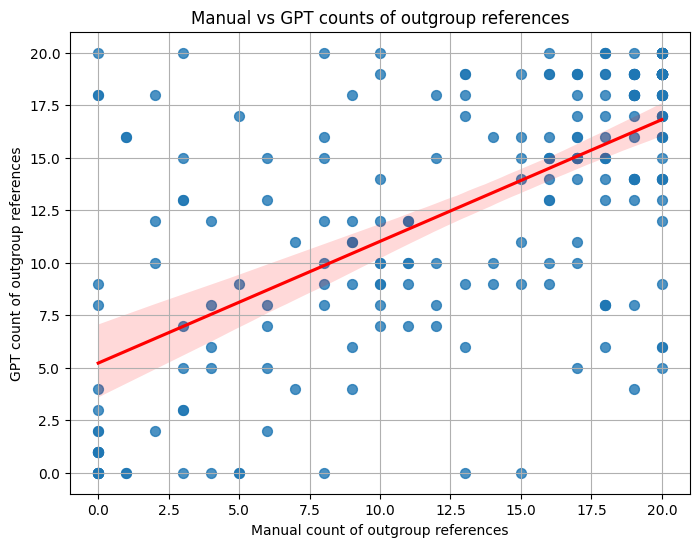

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.regplot(x=df_words["manual"], y=df_words["gpt"], scatter_kws={'s':50}, line_kws={'color':'red'})
plt.xlabel("Manual count of outgroup references")
plt.ylabel("GPT count of outgroup references")
plt.title("Manual vs GPT counts of outgroup references")
plt.grid(True)
plt.show()

In [25]:
# Only words with more than 15 occurrences in both manual and GPT counts
selected_words = [word for word in df_words.index if df_words.loc[word, "manual"] > 14 and df_words.loc[word, "gpt"] > 14]
print(f"{len(selected_words)} words selected for embedding analysis")

94 words selected for embedding analysis


In [26]:
print(selected_words)

['gouvernement', 'moutons', 'flics', 'covidistes', 'élites', 'vaccinés', 'médias', 'fdo', 'lobotomisés', 'dirigeants', 'préfets', 'boomers', 'macronistes', 'esclaves', 'politiciens', 'gouvernants', 'tyrans', 'dictateurs', 'terroristes sanitaires', 'politicards', 'vendus', 'larbins', 'lâches', 'enfermistes', 'tarés', 'escrocs', 'collabos', 'charlatans', 'crapules', 'mougeons', 'décérébrés', 'nantis', 'fachos', 'dociles', 'journalistes', 'naïfs', 'clowns', 'hypocondriaques', 'merdias', 'président', 'ministres', 'alarmistes', 'bobos', 'monstres', 'pourritures', 'manipulateurs', 'parasites', 'salauds', 'socialistes', 'macronards', 'spikés', 'dosés', 'vaxxinés', 'labos', 'journaleux', 'menteurs', 'khmers', 'hypnotisés', 'pleutres', 'toutous', 'veaux', 'obéissants', 'ayatollahs', 'godillots', 'sbires', 'fascistes', 'toubibs', 'laboratoires', 'guignols', 'voyous', 'talibans', 'endoctrinés', 'journalopes', 'lobbies', 'hystériques', 'assassins', 'minables', 'sorciers', 'apeurés', 'traitres', 'e

In [27]:
import re
from collections import Counter

# Function to compute normalized frequencies for a list of words
def normalized_word_freq(df, words):
    counter = Counter()
    for text in df['preprocessed_text']:
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        counter.update([t for t in tokens if t in words])
    total_tweets = len(df)
    normalized = {word: counter[word]/total_tweets for word in words}
    return normalized

# Compute normalized frequencies before and after July 12
freq_before_selected = normalized_word_freq(df_before_july, selected_words)
freq_after_selected = normalized_word_freq(df_after_july, selected_words)

# Create a DataFrame
df_selected_freq = pd.DataFrame({
    'before': pd.Series(freq_before_selected),
    'after': pd.Series(freq_after_selected)
}).fillna(0)

# Compute change
df_selected_freq['diff'] = df_selected_freq['after'] - df_selected_freq['before']
df_selected_freq['pct_change'] = df_selected_freq['diff'] / (df_selected_freq['before'] + 1e-6) * 100

/tmp/ipython-input-3592959124.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diff', y=df_plot.index, data=df_plot, palette='coolwarm')


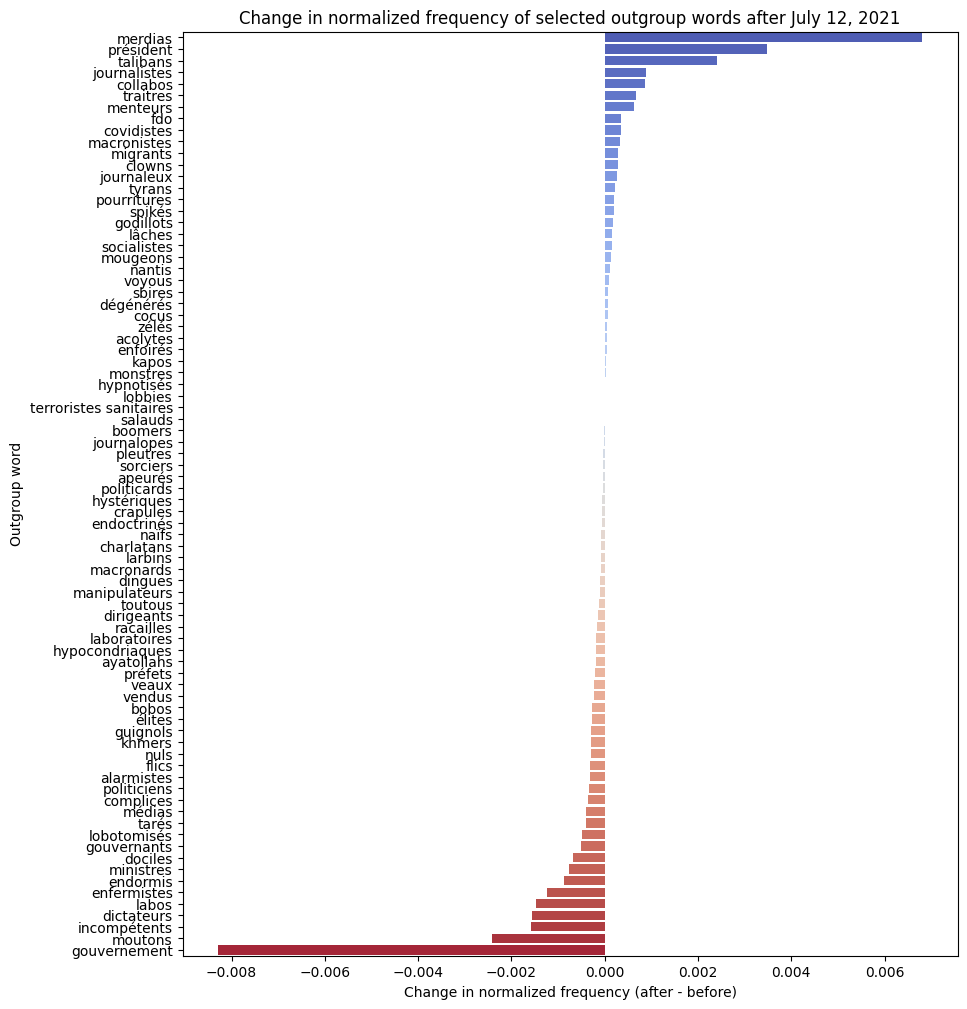

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by largest increase
df_plot = df_selected_freq.sort_values('diff', ascending=False)

plt.figure(figsize=(10,12))
sns.barplot(x='diff', y=df_plot.index, data=df_plot, palette='coolwarm')
plt.title("Change in normalized frequency of selected outgroup words after July 12, 2021")
plt.xlabel("Change in normalized frequency (after - before)")
plt.ylabel("Outgroup word")
plt.show()

In [28]:
from statsmodels.stats.proportion import proportions_ztest

significant_words = []

for word in df_selected_freq.index:
    # Counts before and after
    count_before = int(freq_before_selected.get(word, 0) * len(df_before_july))
    nobs_before = len(df_before_july)
    count_after = int(freq_after_selected.get(word, 0) * len(df_after_july))
    nobs_after = len(df_after_july)

    # z-test for proportions
    counts = [count_before, count_after]
    nobs = [nobs_before, nobs_after]
    stat, pval = proportions_ztest(counts, nobs)

    if pval < 0.05:  # significant at 5%
        significant_words.append(word)

print(f"{len(significant_words)} words changed significantly")

53 words changed significantly


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


/tmp/ipython-input-3469887124.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diff', y=df_significant.index, data=df_significant, palette='coolwarm')


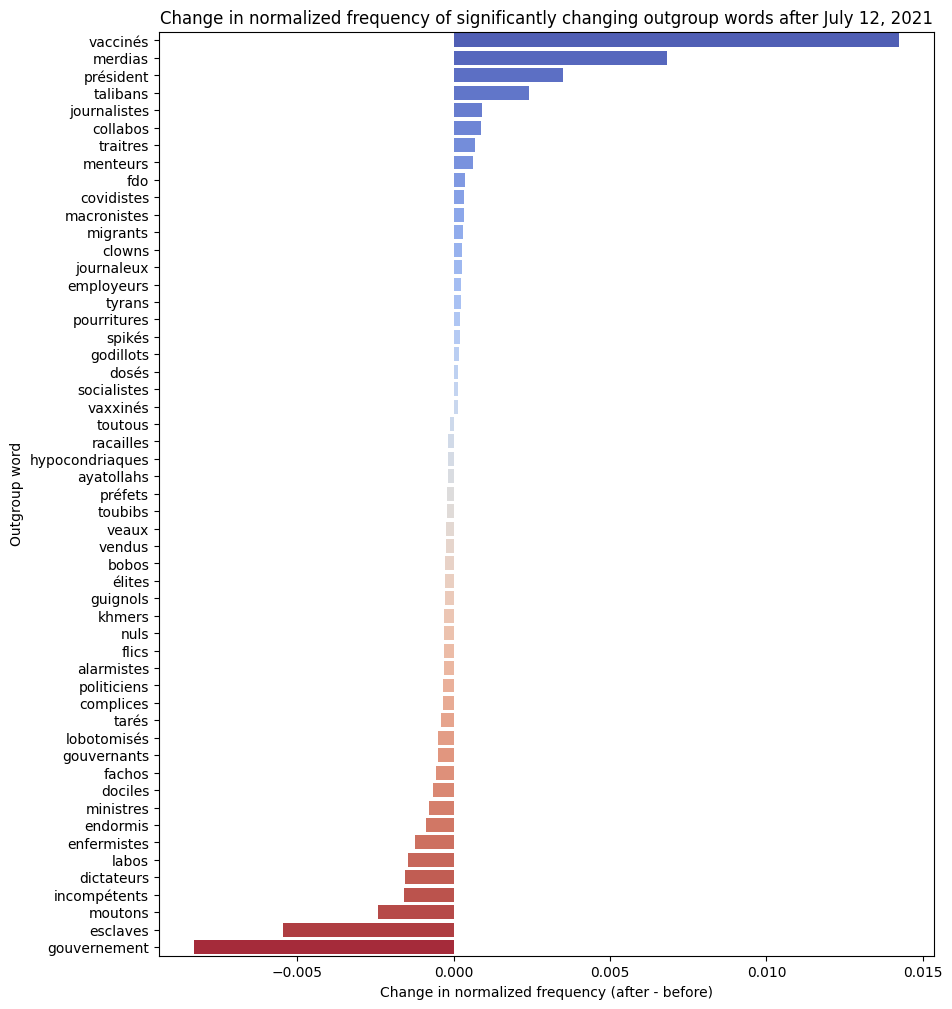

In [30]:
# Filter the DataFrame
df_significant = df_selected_freq.loc[significant_words].sort_values('diff', ascending=False)

plt.figure(figsize=(10,12))
sns.barplot(x='diff', y=df_significant.index, data=df_significant, palette='coolwarm')
plt.title("Change in normalized frequency of significantly changing outgroup words after July 12, 2021")
plt.xlabel("Change in normalized frequency (after - before)")
plt.ylabel("Outgroup word")
plt.show()

/tmp/ipython-input-1026146225.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


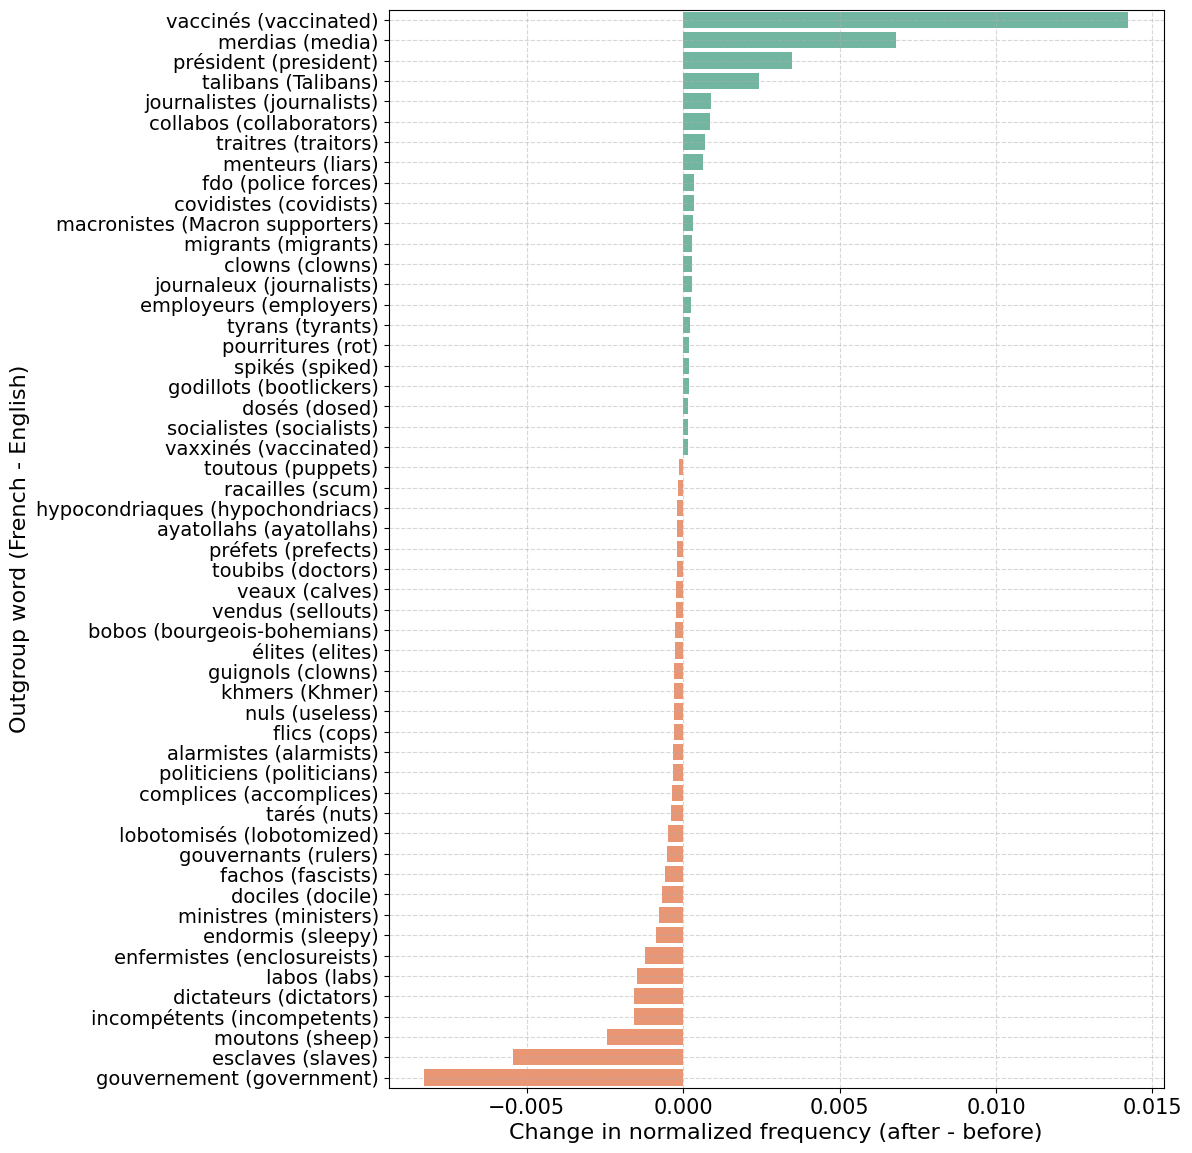

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example translation dictionary (you can expand this)
translations = {
    'gouvernement': 'government', 'moutons': 'sheep', 'flics': 'cops', 'covidistes': 'covidists',
    'élites': 'elites', 'vaccinés': 'vaccinated', 'fdo': 'police forces', 'lobotomisés': 'lobotomized',
    'préfets': 'prefects', 'macronistes': 'Macron supporters', 'esclaves': 'slaves', 'politiciens': 'politicians',
    'gouvernants': 'rulers', 'tyrans': 'tyrants', 'dictateurs': 'dictators', 'vendus': 'sellouts',
    'enfermistes': 'enclosureists', 'tarés': 'nuts', 'collabos': 'collaborators', 'fachos': 'fascists',
    'dociles': 'docile', 'journalistes': 'journalists', 'clowns': 'clowns', 'hypocondriaques': 'hypochondriacs',
    'merdias': 'media', 'président': 'president', 'ministres': 'ministers', 'alarmistes': 'alarmists',
    'bobos': 'bourgeois-bohemians', 'pourritures': 'rot', 'socialistes': 'socialists', 'spikés': 'spiked',
    'dosés': 'dosed', 'vaxxinés': 'vaccinated', 'labos': 'labs', 'journaleux': 'journalists',
    'menteurs': 'liars', 'khmers': 'Khmer', 'toutous': 'puppets', 'veaux': 'calves', 'ayatollahs': 'ayatollahs',
    'godillots': 'bootlickers', 'toubibs': 'doctors', 'guignols': 'clowns', 'talibans': 'Talibans',
    'traitres': 'traitors', 'endormis': 'sleepy', 'racailles': 'scum', 'migrants': 'migrants',
    'incompétents': 'incompetents', 'nuls': 'useless', 'employeurs': 'employers', 'complices': 'accomplices'
}

# Set Seaborn palette
sns.set_palette("Set2")
regular_color_new_users = sns.color_palette("Set2")[0]  # e.g., greenish
regular_color_persistent_users = sns.color_palette("Set2")[1]  # e.g., purplish

# Add translation column
df_significant['translation'] = df_significant.index.map(translations)

# Assign color based on sign of 'diff'
def color_map_fixed(val):
    return regular_color_new_users if val >= 0 else regular_color_persistent_users

colors = df_significant['diff'].apply(color_map_fixed).tolist()

# Create plot
plt.figure(figsize=(10,14))
sns.barplot(
    x='diff',
    y=df_significant.index + " (" + df_significant['translation'] + ")",
    data=df_significant,
    palette=colors
)
#plt.title("Change in normalized frequency of significantly changing outgroup words after July 12, 2021")
plt.xlabel("Change in normalized frequency (after - before)", fontsize=16)
plt.ylabel("Outgroup word (French - English)", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(path_folder+"figures/outgrouplabels_frequency.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(selected_words)

['gouvernement', 'moutons', 'flics', 'covidistes', 'élites', 'médias', 'fdo', 'lobotomisés', 'dirigeants', 'préfets', 'boomers', 'macronistes', 'politiciens', 'gouvernants', 'tyrans', 'dictateurs', 'terroristes sanitaires', 'politicards', 'vendus', 'larbins', 'lâches', 'enfermistes', 'tarés', 'collabos', 'charlatans', 'crapules', 'mougeons', 'nantis', 'dociles', 'journalistes', 'naïfs', 'clowns', 'hypocondriaques', 'merdias', 'président', 'ministres', 'alarmistes', 'bobos', 'monstres', 'pourritures', 'manipulateurs', 'salauds', 'socialistes', 'macronards', 'spikés', 'labos', 'journaleux', 'menteurs', 'khmers', 'hypnotisés', 'pleutres', 'toutous', 'veaux', 'ayatollahs', 'godillots', 'sbires', 'laboratoires', 'guignols', 'voyous', 'talibans', 'endoctrinés', 'journalopes', 'lobbies', 'hystériques', 'sorciers', 'apeurés', 'traitres', 'enfoirés', 'kapos', 'zélés', 'dingues', 'endormis', 'cocus', 'dégénérés', 'racailles', 'migrants', 'incompétents', 'nuls', 'acolytes', 'complices']


# IV. Categorize and visualise their prevalence

In [ ]:
# Set a new color palette using seaborn
color_palette = sns.color_palette("Paired")

category_colors = color_palette

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['week'] = df['created_at'].dt.strftime('%Y-%U')

# Calculate the top 10% authors who publish the most
top_10_percent_authors = df['author_id'].value_counts().nlargest(int(len(df['author_id'].unique()) * 0.1)).index

# Filter the DataFrame based on the top 10% authors
df_top_10_percent = df[df['author_id'].isin(top_10_percent_authors)]

# Function to filter authors based on the new condition
def filter_activists(df):
    # Get the number of unique months each author has posted in
    author_post_months = df.groupby('author_id')['created_at'].apply(lambda x: x.dt.month.nunique())

    # Filter authors who have posted in every month
    prolific_authors = author_post_months[author_post_months >= 10].index

    # Filter the DataFrame based on prolific authors
    df_activists = df[df['author_id'].isin(prolific_authors)]

    return df_activists

# Apply the prolific condition to the original DataFrame
df_activists = filter_activists(df_top_10_percent)

# Define the start date (July 12th, 2021)
start_date = '2021-28'

# Get the first post date for each author in the entire dataset
first_post_dates = df.groupby('author_id')['week'].min()

# Identify authors who first posted on July 12th, 2021
first_post_july_12th = first_post_dates[first_post_dates == start_date].index

# Filter the dataset to include only authors who first posted on July 12th, 2021
authors_started_on_july_12th_df = df[df['author_id'].isin(first_post_july_12th)]

# Filter the dataset to include only authors who continued posting after July 12th, 2021
#authors_posted_after_july_12th = authors_posted_on_july_12th[authors_posted_on_july_12th['week'] > start_date]

# Filter the data to include only authors who posted after July 12th, 2021
#filtered_df_posted_after_july_12th = df[df['author_id'].isin(authors_posted_after_july_12th['author_id'])]

# Define the function to filter authors based on the new condition
def filter_authors_stopped(df, first_post_july_12th):
    # Get the last post date for each author in the entire dataset
    last_post_dates = df.groupby('author_id')['week'].max()

    # Identify authors who first posted on 2021-28 and never posted after
    last_post_july_12th = last_post_dates[last_post_dates == '2021-28'].index
    first_last_post_july_12th = list(set(last_post_july_12th).intersection(set(first_post_july_12th)))

    # Filter the dataset to include only authors who first posted on 2021-28 and never posted after
    authors_stopped_df = df[df['author_id'].isin(first_last_post_july_12th)]

    return authors_stopped_df

# Apply the new condition to the original DataFrame
authors_stopped_df = filter_authors_stopped(df, first_post_july_12th)

# Get the index of authors to be removed
authors_to_remove_index = authors_started_on_july_12th_df[authors_started_on_july_12th_df['author_id'].isin(authors_stopped_df['author_id'])].index

# Remove authors from authors_posted_on_july_12th
authors_continued_df = authors_started_on_july_12th_df.drop(authors_to_remove_index)

# Get the list of all author IDs in the DataFrame
all_authors = df['author_id'].unique()

# Get the list of authors who are prolific
activists_list = df_activists['author_id'].unique()

# Get the list of authors who started but did not continue
stopped_authors_list = authors_stopped_df['author_id'].unique()

# Get the list of authors who started and continue
continued_authors_list = authors_continued_df['author_id'].unique()

# # Create a list of authors not included in any of the other groups
# other_authors_list = [author for author in all_authors if author not in activists_list
#                       and author not in stopped_authors_list and author not in continued_authors_list]

# # Filter the DataFrame to include only authors in the "other" group
# df_other_authors = df[df['author_id'].isin(other_authors_list)]

# Step 1: Identify authors who started posting before 2021-28
authors_started_before_july_12th = first_post_dates[first_post_dates < '2021-28'].index

# Step 2: Ensure these authors are not part of the activists, stopped, or continued groups
# Create a set of authors who are not activists, stopped, or continued
excluded_authors = set(activists_list).union(stopped_authors_list).union(continued_authors_list)

# Filter out authors who are in the excluded groups
other_authors_list = [author for author in authors_started_before_july_12th if author not in excluded_authors]

# Step 3: Filter the DataFrame to include only authors in the "other" group
df_other_authors = df[df['author_id'].isin(other_authors_list)]

In [ ]:
print(len(activists_list), len(stopped_authors_list), len(continued_authors_list), len(other_authors_list))

427 3321 2068 8931


In [ ]:
len(df.author_id.unique())

27016

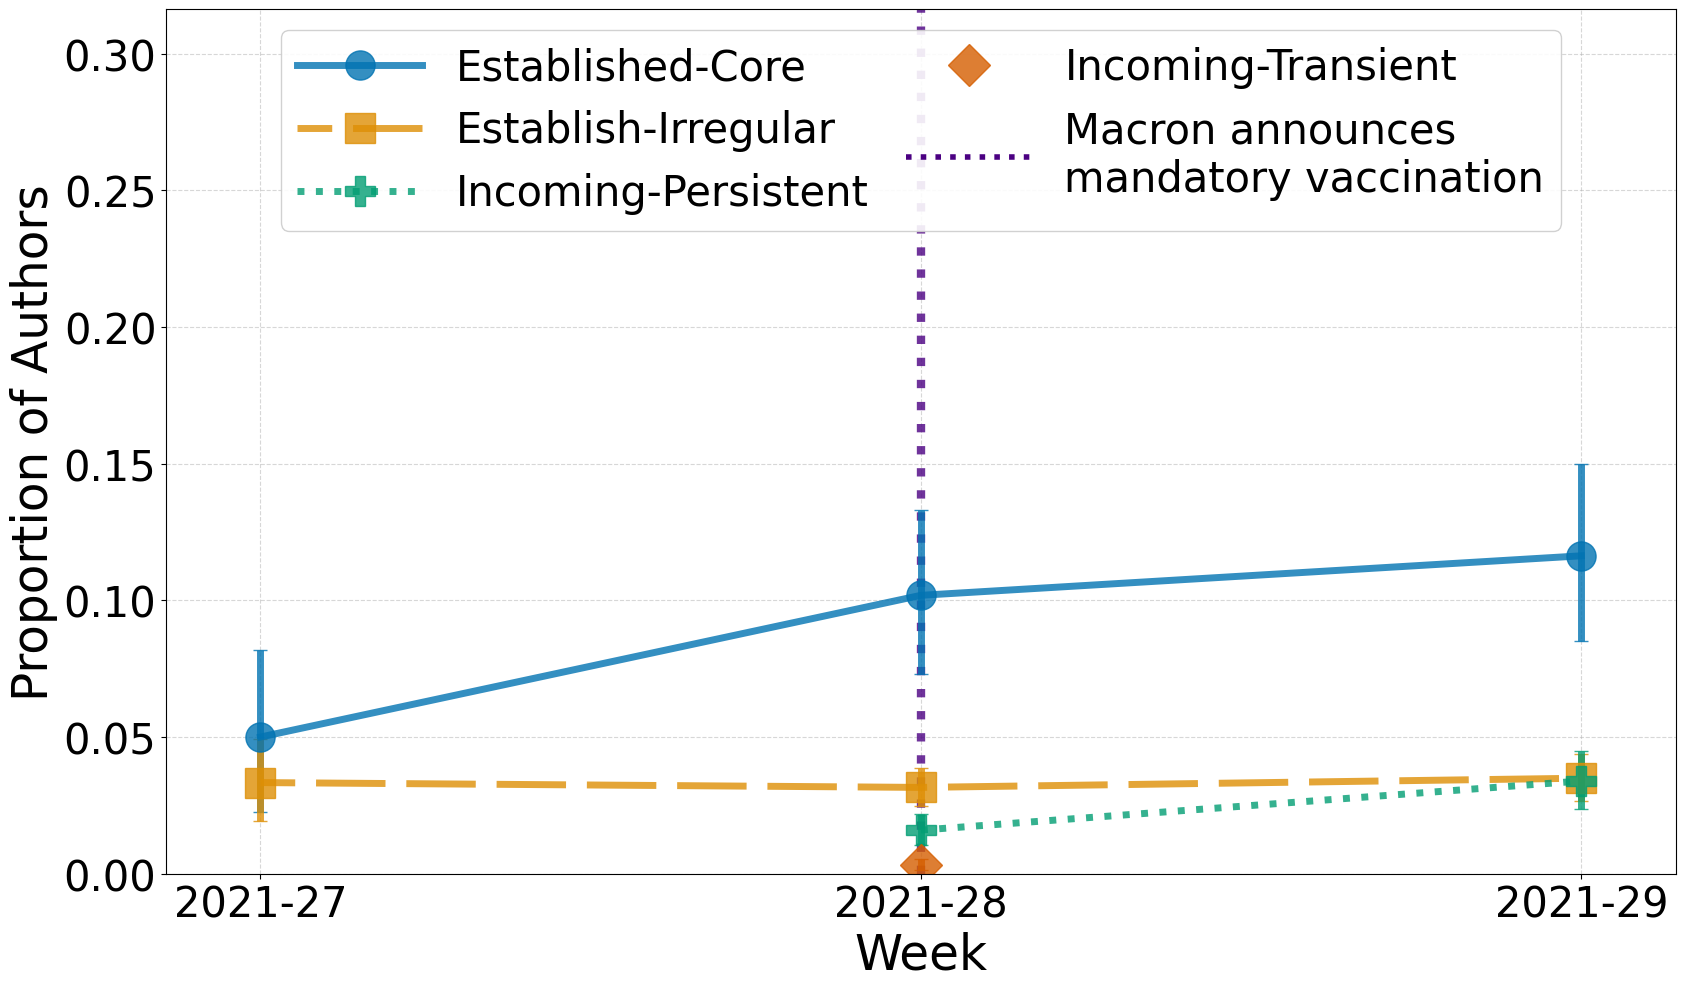

In [ ]:
# Ensure 'created_at' is a datetime object and 'week' is correctly formatted
df['created_at'] = pd.to_datetime(df['created_at'])
df['week'] = df['created_at'].dt.strftime('%Y-%U')

# Set a new color palette using seaborn
color_palette = sns.color_palette("colorblind")

# Define custom colors for different outgroup word categories
highlight_line_color = '#4B0082'
category_colors = color_palette#[:len(category_words)]

# Define markers for each category
markers = ['o', 's', 'P', 'D']#[:len(category_words)]  # Using different shapes for variety
linestyles = ['solid', (5, (10, 3)), 'dotted', '']#[:len(category_words)]

# Define the weeks of interest
weeks_of_interest = ['2021-27', '2021-28', '2021-29']

# Convert weeks of interest to datetime
weeks_of_interest_dates = [pd.to_datetime(f'{week}-1', format='%Y-%U-%w') for week in weeks_of_interest]

# Filter the DataFrame to include only these weeks
df_filtered_weeks = df[df['week'].isin(weeks_of_interest)]

# Dictionary of author groups
author_groups = {
    'Established-Core': activists_list,
    'Establish-Irregular': other_authors_list,
    'Incoming-Persistent': continued_authors_list,
    'Incoming-Transient': stopped_authors_list
}

# Initialize dictionary to store proportions and confidence intervals for each author group
group_proportions = {group_name: [] for group_name in author_groups.keys()}
group_conf_intervals = {group_name: [] for group_name in author_groups.keys()}

# Iterate over the weeks of interest
for week in weeks_of_interest:
    # Filter the DataFrame for the current week
    week_df = df_filtered_weeks[df_filtered_weeks['week'] == week]

    # Iterate through each author group
    for group_name, author_ids in author_groups.items():
        # Filter week data for this author group
        group_week_df = week_df[week_df['author_id'].isin(author_ids)]

        # Count unique authors using any word from the outgroup list
        authors_using_outgroup = set()
        for author_id, tokens in zip(group_week_df['author_id'], group_week_df['tokenized_text']):
            if any(word in tokens for word in selected_words):
                authors_using_outgroup.add(author_id)

        # Calculate the proportion of authors in this group using outgroup words
        total_authors_in_group = len(group_week_df['author_id'].unique())
        count_using_outgroup = len(authors_using_outgroup)
        proportion_using_outgroup = count_using_outgroup / total_authors_in_group if total_authors_in_group > 0 else 0

        # Calculate 95% confidence intervals using the binomial proportion confidence interval
        if total_authors_in_group > 0:
            conf_interval = binom.interval(0.95, total_authors_in_group, proportion_using_outgroup, loc=0)
            conf_interval = [ci / total_authors_in_group for ci in conf_interval]  # Convert counts to proportions
        else:
            conf_interval = [0, 0]

        # Append proportion and confidence intervals to the corresponding group
        group_proportions[group_name].append(proportion_using_outgroup)
        group_conf_intervals[group_name].append(conf_interval)

# Create a DataFrame to store the proportions
group_proportions_df = pd.DataFrame({
    'Week': weeks_of_interest_dates,
    **group_proportions
})

# Create a new figure
fig, ax = plt.subplots(figsize=(17, 10))

# Define Macron's announcement date and the end date for shading
announcement_date = pd.to_datetime('2021-28-1', format='%Y-%U-%w')
end_date = announcement_date + pd.DateOffset(weeks=2)

# Add the dotted red line for Macron's announcement
#ax.axvline(x=announcement_date, color=highlight_line_color, linestyle='dotted', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

# Vertical line for Macron speech
ax.axvline(x=announcement_date, color=highlight_line_color, linestyle='dotted', linewidth=6, alpha=0.8)

# Extend the shaded area from the announcement date to 2 weeks after
#ax.axvspan(announcement_date, end_date, facecolor="grey", alpha=0.08, zorder=0)

# Plot the proportions with error bars (confidence intervals)
for i, group_name in enumerate(group_proportions.keys()):
    non_zero_weeks = [week for i, week in enumerate(group_proportions_df['Week']) if group_proportions_df[group_name][i] > 0]
    non_zero_proportions = [prop for prop in group_proportions_df[group_name] if prop > 0]
    non_zero_conf_intervals = [group_conf_intervals[group_name][i] for i, prop in enumerate(group_proportions_df[group_name]) if prop > 0]
    lower_bounds, upper_bounds = zip(*non_zero_conf_intervals)

    plt.errorbar(non_zero_weeks, non_zero_proportions, yerr=[np.subtract(non_zero_proportions, lower_bounds),
                                                             np.subtract(upper_bounds, non_zero_proportions)],
                 marker=markers[i], linestyle=linestyles[i], label=group_name, capsize=5, c=category_colors[i], linewidth=5, ms=21, alpha=0.8)

# Set axis labels
plt.xlabel('Week', fontsize=35)
plt.ylabel('Proportion of Authors', fontsize=35)

# Customize x-ticks and labels
plt.xticks(weeks_of_interest_dates, [week.strftime('%Y-%U') for week in weeks_of_interest_dates], fontsize=30)
plt.yticks(fontsize=30)

# Adjust axis limits
ax.set_xlim(weeks_of_interest_dates[0] - pd.DateOffset(weeks=0.2), weeks_of_interest_dates[-1] + pd.DateOffset(weeks=0.2))
ax.set_ylim(0, max(max(group_proportions_df[group_name]) for group_name in group_proportions.keys()) + 0.2)

# Create custom legend handles
handles = [
    mlines.Line2D([0], [0], color=category_colors[i], marker=markers[i], linestyle=linestyles[i],
                  markersize=21, linewidth=5, label=group_name, alpha=0.8)
    for i, group_name in enumerate(group_proportions.keys())
] + [
    mlines.Line2D([0], [0], color=highlight_line_color, linestyle='dotted', linewidth=4,
                  label='Macron announces\nmandatory vaccination')  # Added newline
]

    #mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')  # Adding grey area to the legend
#]

# Place the legend below the plot with fewer columns and adjust spacing
ax.legend(handles=handles, fontsize=30, loc='upper center', ncol=2, framealpha=0.9, columnspacing=0.9, handlelength=3)

# Enable grid
ax.grid(True, linestyle='--', alpha=0.5)

# Final plot adjustments
plt.tight_layout()
plt.savefig(path_folder+"figures/outgroup_author_groups_evolution.png", dpi=200)
plt.show()